# <b> 0. IMPORTING LIBRARIES

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2 as cv
# from tqdm import tqdm
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten  # , InputLayer ,Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU  #, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
import xml.etree.ElementTree as ET


In [2]:
%config Completer.use_jedi = False
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

print('Done!!')

Done!!


# <b> 1. CREATING PATHS TO DIRECTORIES

In [3]:
#files path in a dictionary
paths = dict()
# Linux pc
# paths['main'] = '/home/javi/Desktop/Python/MNIST_OD'
# paths['dataset'] = os.path.join(paths['main'], 'MNIST_dataset')
# paths['train_data'] = os.path.join(paths['dataset'], 'train')
# paths['test_data'] = os.path.join(paths['dataset'], 'test')
# Windows pc
paths['main'] = os.path.normcase('D:\Javi\Python\MNIST_OD')#.replace('\\','/'))
paths['dataset'] = os.path.join(paths['main'], 'MNIST_dataset')
paths['train_data'] = os.path.join(paths['dataset'], 'train')
paths['test_data'] = os.path.join(paths['dataset'], 'test')
paths['models'] = os.path.join(paths['main'], 'MNIST_model')
paths['model11M'] = os.path.join(paths['models'], 'model11M')
paths['model11M_CP'] = os.path.join(paths['model11M'], 'checkpoints')

# <b> 2. CREATING THE YOLO LIKE MODEL

## 2.1 Neuronal network model

In [4]:
class Yolo_Reshape(tf.keras.layers.Layer):
    def __init__(self, grid_size=7, no_bnb=2, no_class=10):
        super(Yolo_Reshape, self).__init__()
        self.grid_size = grid_size
        self.no_of_bnb = no_bnb
        self.no_class = no_class

    def call(self, inputs):
        # grids 7x7
        S = [self.grid_size, self.grid_size]
        # classes
        C = self.no_class
        # no of bounding boxes per grid
        B = self.no_of_bnb

        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B

        # class probabilities
        class_probs = tf.reshape(inputs[:, :idx1], (tf.shape(inputs)[0],) + tuple([S[0], S[1], C]))
        class_probs = tf.nn.softmax(class_probs, axis=-1)

        # confidence
        confs = tf.reshape(inputs[:, idx1:idx2], (tf.shape(inputs)[0],) + tuple([S[0], S[1], B]))
        confs = tf.math.sigmoid(confs)

        # boxes
        boxes = tf.reshape(inputs[:, idx2:], (tf.shape(inputs)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = tf.math.sigmoid(boxes)

        outputs = tf.concat([class_probs, confs, boxes], axis=3)
        return outputs

In [6]:
class MNIST_YOLO(tf.keras.Model):
    def __init__(self, inpshape, bocks_info,
                 grid_size=7, no_of_bnb=2, no_class=10):
        super().__init__()
        self.nConvs = 0
        self.nBlocks = 0
        self.grid_size = grid_size
        self.no_of_bnb = no_of_bnb
        self.no_class = no_class
        self.bocks_info = bocks_info
        self.inpshape = inpshape
        self.layersList = list()
        self.inplayer = Conv2D(64, kernel_size=7, strides=1,
                               # input_shape=(inpshape),
                               activation=LeakyReLU(alpha=0.2),
                               kernel_regularizer=l2(5e-4),
                               name='conv2D_init')
        self.maxPoolinplayer = MaxPooling2D(pool_size=2, strides=2, name='Mpooling_init')
        for key, val in self.bocks_info.items():
            if key.startswith('m'):
                self.block_CN_gen(val, self.layersList, maxpooling=True)
            else:
                self.block_CN_gen(val, self.layersList, maxpooling=False)

        self.final_conv = Conv2D(512, kernel_size=3, strides=1,
                                 activation=LeakyReLU(alpha=0.2),
                                 name='conv2D_last')

        self.flatten = Flatten()
        self.dense_1 = Dense((self.no_class+self.no_of_bnb*5)*self.grid_size**2/4)
        self.drop = Dropout(0.3)
        self.dense_2 = Dense((self.no_class+self.no_of_bnb*5)*self.grid_size**2/2)
        self.dense_3 = Dense((self.no_class+self.no_of_bnb*5)*self.grid_size**2,
                              activation='sigmoid')
        self.reshape = Yolo_Reshape(self.grid_size, self.no_of_bnb, self.no_class)

    def block_CN_gen(self, dictionary_info, layers_list, maxpooling=True):
        '''generate a block of convolutions
        dictionary_info : dict of list {kernel_list, stride_list, padding}'''
        for key, (filt, ker, stride, pad, act) in dictionary_info.items():
            layer_name = 'block{}_conv{}'.format(self.nBlocks, self.nConvs)
            layers_list.append(Conv2D(filt, kernel_size=ker, strides=stride,
                                      padding=pad,
                                      activation=act,
                                      kernel_regularizer=l2(5e-4),
                                      name=layer_name))
            self.nConvs += 1
        if maxpooling:
            layers_list.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                                            padding='same',
                                            name='Mpooling_block{}'.format(self.nBlocks)))
        self.nBlocks += 1

    def call(self, inputs):
        # inputs = self.InputLayer
        x = self.inplayer(inputs)
        x = self.maxPoolinplayer(x)
        for layer in self.layersList:
            x = layer(x)
        x = self.final_conv(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.drop(x)
        x = self.dense_3(x)
        x = self.reshape(x)
        return x  # Model(inputs,x)

    def summary(self):
        inp = Input(shape=self.inpshape, name="input_layer")
        model = Model(inputs=[inp], outputs=self.call(inp))
        model.summary()
        del inp, model
        # return model.summary()


blocks_dict = {'mblock1': {'b1': [128, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b2': [64, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b3': [64, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)]},
               'mblock2': {'b1': [64, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b2': [128, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b3': [128, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b4': [256, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)],},
               'mblock3': {'b1': [256, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b2': [512, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b3': [256, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b4': [512, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b5': [256, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b6': [512, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b7': [512, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.2)],
                           'b8': [512, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.2)]}}#,
                          # 'b5': [512, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.1)],
                          # 'b6': [1024, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.1)]}}
               # 'block4': {'b1': [256, (1, 1), (1, 1), 'same', LeakyReLU(alpha=0.1)],
               #            'b2': [256, (3, 3), (1, 1), 'same', LeakyReLU(alpha=0.1)]}}


# mini_yolo = MNIST_YOLO(inpshape=(144, 144, 1),
#                        bocks_info=blocks_dict,
#                        grid_size=7, no_of_bnb=2,
#                        no_class=10
#                        )

# mini_yolo.summary()

# inputs = Input(shape=(144, 144, 1), name="input_layer")
# outputs = mini_yolo(inputs)
# mini_yolo = Model(inputs=inputs, outputs=outputs)
# mini_yolo.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 144, 144, 1)]     0         
                                                                 
 conv2D_init (Conv2D)        (None, 138, 138, 64)      3200      
                                                                 
 Mpooling_init (MaxPooling2D  (None, 69, 69, 64)       0         
 )                                                               
                                                                 
 block0_conv0 (Conv2D)       (None, 69, 69, 128)       73856     
                                                                 
 block0_conv1 (Conv2D)       (None, 69, 69, 64)        8256      
                                                                 
 block0_conv2 (Conv2D)       (None, 69, 69, 64)        36928     
                                                           

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

img_w=144
img_h=144

model = Sequential()
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(1, 1), input_shape =(img_h, img_w, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=512, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
# model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))

model.add(Flatten())
model.add(Dense((7*7*15/2)))
model.add(Dense(7*7*15))
model.add(Dropout(0.5))
model.add(Dense(7*7*15, activation='sigmoid'))
model.add(Yolo_Reshape(grid_size=7, no_bnb=1, no_class=10))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 144, 144, 64)      3200      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 192)       110784    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 192)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 36, 36, 128)       24704     
                                                                 
 conv2d_15 (Conv2D)          (None, 36, 36, 256)      

## 2.2 Creating a custom loss function

In [ ]:
# tensorA = np.arange(1*7*7*15).reshape([1,7,7,15])
# tensorA = tf.Variable(tensorA)
# tensorB = np.arange(1*7*7*15).reshape([1,7,7,15])*2
# tensorB = tf.Variable(tensorB)
# # tf.concat([tensorA,tensorA*2,tensorA*3],axis=-1)
# # tf.math.reduce_sum(tf.subtract(tensorB,tensorA),axis=-1)
# tensorB[:,:,:,0:1]<=200

In [7]:
class yolo_loss_function(tf.keras.losses.Loss):
    '''
    This class is the loss function for yolo_v1, which is divided in
    in 4 parts
    '''

    def __init__(self, grid_size=7, no_of_bnb=2, no_class=10):
        '''Initialating que variables depending on the accuracy of the NN'''
        super().__init__()
        self.grid_size = grid_size
        self.no_of_bnb = no_of_bnb
        self.no_class = no_class
        self.coord_param = 5.0
        self.noobj_param = 0.5

    def get_xy_wh_global(self, xy_local_tensor):
        '''
        Translating the local coordintes (grid) xy,
        in global coordinates (picture) -> [0,1]
        Args:
        -xy_local tensor: tf tensor with local coorinates
        return: xy tensor in global coodinates
        '''
        # shape = xy_local_tensor.shape[0]
        # (x -> row, y -> columns) Index
        # 0,0 is the left-top corner and 6,6 is the rigth-bot corner of the matrix
        x_global = tf.range(0, self.grid_size, delta=1, dtype=tf.float32, name='range')
        x_global = tf.expand_dims(x_global, axis=0)
        x_global = tf.expand_dims(x_global, axis=0)
        x_global = tf.tile(x_global, [1, self.grid_size, 1])  # 1,1,7 -> 1,7,7
        x_global = tf.expand_dims(x_global, axis=-1)          # 1,7,7,1
        y_global = tf.range(0, self.grid_size, delta=1, dtype=tf.float32, name='range')
        y_global = tf.expand_dims(y_global, axis=0)
        y_global = tf.expand_dims(y_global, axis=-1)
        y_global = tf.tile(y_global, [1, 1, self.grid_size])  # 1,7,1 -> 1,7,7
        y_global = tf.expand_dims(y_global, axis=-1)          # 1,7,7,1
        xy_global = tf.concat([x_global, y_global], axis=-1)  # 1,7,7,2
        # print(xy_global.shape)
        # xy_global = tf.tile(xy_global, [shape, 1, 1, 1])
        xy_global = tf.add(xy_local_tensor, xy_global)
        xy_global = tf.multiply(xy_global, 1/self.grid_size)  # tranlate to global coords from 0 to 1
        return xy_global

    def xy_minmax(self, xy_tensor, wh_tensor):
        '''
        Transform bnb xy centered coordinates in
        xy_minmax corners of the bnb
        Args:
        -xy_tensor: tf tensor with xy centered coordinates
        -wh_tensor: tf tensor wiht wh
        return xy_min, xy_max corners of the bnb
        '''
        xy_min = xy_tensor - wh_tensor/2  # left-top
        xy_max = xy_tensor + wh_tensor/2  # rigth-bot
        return xy_min, xy_max

    def iou(self, xy_pred_mins, xy_pred_maxes, xy_true_mins, xy_true_maxes):
        intersection_min = tf.math.maximum(xy_pred_mins, xy_true_mins)     # ?*7*7*2
        intersection_max = tf.math.minimum(xy_pred_maxes, xy_true_maxes)   # ?*7*7*2
        # Calculate the intersection distance w, h -> if it is negative,
        # there is not intersection, so use 0
        # Aquí habia un fallo la siguiente operacion era tf.math.minimum
        intersection = tf.math.maximum(tf.subtract(intersection_max, intersection_min), 0.0)  # ?*7*7*2
        intersection = tf.multiply(intersection[:, :, :, 0], intersection[:, :, :, 1])        # ?*7*7

        pred_area = tf.subtract(xy_pred_maxes, xy_pred_mins)                   # ?*7*7*2
        pred_area = tf.multiply(pred_area[:, :, :, 0], pred_area[:, :, :, 1])  # ?*7*7
        true_area = tf.subtract(xy_true_maxes, xy_true_mins)                   # ?*7*7*2
        true_area = tf.multiply(true_area[:, :, :, 0], true_area[:, :, :, 1])  # ?*7*7

        union_areas = pred_area + true_area - intersection  # ?*7*7
        iou_scores = intersection / union_areas             # ?*7*7
        iou_scores = tf.expand_dims(iou_scores, axis=-1)    # ?*7*7*1

        return iou_scores

    def choose_max(self, list_of_tensor):
        tensor_shape = tf.shape(list_of_tensor[0])
        for t, tensor in enumerate(list_of_tensor):
            if t == 0:
                init_tensor = tensor           # ?*7*7*1
                # this create a mask, -1 is not better possition found
                mask = tf.where(tensor>0.0, 0.0, -1.0)  # ?*7*7*1
            else:
                init_tensor = tf.math.maximum(init_tensor, tensor)  # ?*7*7*1
                mask = tf.where(init_tensor == tensor, tf.cast(t, tf.float32), mask)  # ?*7*7*1
        # mask give back a tensor (?,7,7,1) with the position of the greater
        # iou score in the bnb
        # Create a tensor mask for predict
        # tensor_shape.append(self.no_of_bnb)
        for i in range(len(list_of_tensor)):
            if i == 0:
                mask_pred = tf.where(mask == float(i), 1.0, 0.0)
            else:
                mask_pred = tf.concat([mask_pred,
                                       tf.where(mask == float(i), 1.0, 0.0)], axis=-1)

        # Create a tensor mask for bnb
        for i in range(len(list_of_tensor)):
            if i == 0:
                mask_bnb = tf.tile(tf.where(mask == i, 1.0, 0.0), [1, 1, 1, 2])
            else:
                mask_bnb = tf.concat([mask_bnb,
                                      tf.tile(tf.where(mask == i, 1.0, 0.0),
                                              [1, 1, 1, 2])], axis=-1)
        return mask_pred, mask_bnb

    def call(self, y_true, y_pred):
        # batch
        batch_size = tf.cast(tf.shape(y_pred)[0], dtype=tf.float32)
        # True labels
        label_class = y_true[:, :, :, :self.no_class]               # ?*7*7*10
        label_box = y_true[:, :, :, self.no_class:self.no_class+4]  # ?*7*7*4
        response_mask = y_true[:, :, :, -1:]                        # ?*7*7*1
        # Predicted labels
        pred_class = y_pred[:, :, :, :self.no_class]                              # ?*7*7*10
        pred_trust = y_pred[:, :, :, self.no_class:self.no_class+self.no_of_bnb]  # ?*7*7*2
        pred_box = y_pred[:, :, :, self.no_class+self.no_of_bnb:]                 # ?*7*7*8
        # Creating a xy label for the corners of the bnb
        xy_label_box = self.get_xy_wh_global(label_box[:, :, :, :2])              # ?*7*7*2
        wh_label_box = label_box[:, :, :, 2:]                                     # ?*7*7*2
        xy_min_label_box, xy_max_label_box = self.xy_minmax(xy_label_box, wh_label_box)
        xy_pred_box = [self.get_xy_wh_global(pred_box[:, :, :, 4*x:4*x+2]) for x in range(self.no_of_bnb)]  # [?*7*7*2]
        wh_pred_box = [pred_box[:, :, :, 4*x+2:4*x+4] for x in range(self.no_of_bnb)]                       # [?*7*7*2]
        xy_minmax_pred_box = [list(self.xy_minmax(xy, wh)) for xy, wh in zip(xy_pred_box, wh_pred_box)]      # [[?*7*7*2, ?*7*7*2]]]]

        iou_scores = [self.iou(xy_minmax_pred_box[x][0],
                               xy_minmax_pred_box[x][1],
                               xy_min_label_box,
                               xy_max_label_box) for x in range(self.no_of_bnb)]
        mask_pred, mask_bnb = self.choose_max(iou_scores)  # ?*7*7*2, ?*7*7*4

        # Calculating the losses of the centers of the objects
        # coord * SUM(Iobj_i-j((x - xhat)² + (y - yhat)²))
        loss_xy = tf.subtract(tf.concat(xy_pred_box, axis=-1),
                              tf.tile(xy_label_box, [1, 1, 1, self.no_of_bnb]))  # ?*7*7*4
        loss_xy = tf.math.pow(loss_xy, 2)
        loss_xy = tf.multiply(mask_bnb, loss_xy)
        # loss_xy = tf.tile(mask_pred, [1, 1, 1, self.no_of_bnb])*loss_xy          # ?*7*7*4
        loss_xy = tf.tile(response_mask, [1, 1, 1, self.no_of_bnb*2])*loss_xy    # ?*7*7*4
        loss_xy = tf.reduce_sum(loss_xy)/batch_size  # float number
        # print(loss_xy)
        # Calculating the losses of the weith and heigth of the bb
        # coord * SUM(Iobj_i-j((w^0.5 - what^0.5)² + (h^0.5 - hhat^0.5)²))
        loss_wh = tf.subtract(tf.math.sqrt(tf.concat(wh_pred_box, axis=-1)),   # ?*7*7*4
                              tf.math.sqrt(tf.tile(wh_label_box, [1, 1, 1, self.no_of_bnb])))
        # print(loss_wh)
        loss_wh = tf.math.pow(loss_wh, 2)
        loss_wh = tf.multiply(mask_bnb, loss_wh)
        # loss_wh = tf.tile(mask_pred, [1, 1, 1, self.no_of_bnb])*loss_wh        # ?*7*7*4
        loss_wh = tf.tile(response_mask, [1, 1, 1, self.no_of_bnb*2])*loss_wh  # ?*7*7*4
        loss_wh = tf.reduce_sum(loss_wh)/batch_size  # float number
        # print(loss_wh)
        # Calculating the losses of the confidence in the predictions
        # SUM(Iobj_i-j((C - Chat)²)) + no_objt_param*SUM(Inoobj_i-j(h^0.5 - hhat^0.5)²)
        # Inoobj_i-j es de oposite of Iobj_i-j
        loss_conf = pred_trust-tf.tile(response_mask,
                                       [1, 1, 1, self.no_of_bnb])       # ?*7*7*2
        loss_conf = mask_pred*tf.math.pow(loss_conf, 2)                 # ?*7*7*2
        loss_conf_noobj = tf.tile(1-response_mask,
                                  [1, 1, 1, self.no_of_bnb])*loss_conf  # ?*7*7*2
        loss_conf = tf.tile(response_mask,
                            [1, 1, 1, self.no_of_bnb])*loss_conf        # ?*7*7*2
        loss_conf_noobj = tf.reduce_sum(loss_conf_noobj)/batch_size  # float number
        loss_conf = tf.reduce_sum(loss_conf)/batch_size  # float number
        # print(mask_pred)
        # print(tf.tile(response_mask,[1, 1, 1, self.no_of_bnb])*mask_pred)
        # print(tf.tile(response_mask,[1, 1, 1, self.no_of_bnb]))
        # print(loss_conf)
        # print(loss_conf_noobj)
        # Calculating the losses of the classes
        # SUM_everycell(SUM_classes((C - Chat)²))
        classes_loss = tf.subtract(label_class, pred_class)       # ?*7*7*10
        classes_loss = tf.math.pow(classes_loss, 2)               # ?*7*7*10
        classes_loss = tf.math.reduce_sum(classes_loss, axis=-1,
                                          keepdims=True)          # ?*7*7*1
        classes_loss = tf.multiply(response_mask, classes_loss)   # ?*7*7*1
        classes_loss = tf.math.reduce_sum(classes_loss)/batch_size           # float number
        # print(classes_loss)
        # Calculating the total loss
        total_loss = self.coord_param*(loss_xy + loss_wh) + loss_conf + self.noobj_param*loss_conf_noobj + classes_loss
        return total_loss

In [7]:
# leters = [['a','A'],['b','B'],['c','C']]
# num = [['one','1'],['two','2'],['three','3']]
# for let,n in zip(leters,num):
#     print(let,n)

## 2.3 Custom learning rate functions

In [8]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    """
    Learning rate scheduler which sets the learning rate according to schedule.

    Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
    """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.6f." % (epoch+1, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    # (0, 0.001),
    # (1, 0.002),
    # (2, 0.003),
    # (3, 0.002),
    # (5, 0.001),
    # (75, 0.0005),
    # (105, 0.0001),
    (0, 0.005),
    (2, 0.002),
    (5, 0.001),
    # (3, 0.008),
    (10, 0.0005),
    # (15, 0.0001),
    (15, 0.0001),
    # (75, 0.0005),
    # (105, 0.0001),
    # # (40, 0.005),
    # (18, 0.005),
    # # (18, 0.0001),
    # (21, 0.001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

# <b> 3. CREATING THE DATASET TO TRAIN THE NN

## 3.1 Pascal Voc reader

In [9]:
# This is the mapping function for the dataset. The dataset read the
# files of the directory and generate a list of paths, it will return
# a tupple with (image, data_info)

def pascal_voc_to_dict(filepath):
    """
    Function to get all the objects from the annotation XML file.
    Reference axis:
    ->top-left of the image is (0,0) - bot-rigth is (1,1)
    ->y is the heigth and x is the weigth
    """
    # The next 3 lines must be modify if the dataset or nn change:
    grid_size = 7
    no_class = 10
    # no_of_bnb = 2

    with tf.io.gfile.GFile(filepath.numpy().decode(), "r") as f:
        # print(f.read())
        root = ET.parse(f).getroot()

        size = root.find("size")
        image_w = float(size.find("width").text)
        image_h = float(size.find("height").text)
        filePath = str(root.find("path").text)
        img = tf.io.read_file(filePath)
        img = tf.io.decode_jpeg(img, channels=1).numpy()/255.0
        # Setting up the output tensor
        y_true_tensor = np.zeros([grid_size, grid_size, no_class+5])

        for obj in root.findall("object"):
            # Get object's label name.
            label = int(obj.find("name").text)
            # Get objects' pose name.
            # pose = obj.find("pose").text.lower()
            # is_truncated = obj.find("truncated").text == "1"
            # is_difficult = obj.find("difficult").text == "1"
            bndbox = obj.find("bndbox")
            xmax = float(bndbox.find("xmax").text)
            xmin = float(bndbox.find("xmin").text)
            ymax = float(bndbox.find("ymax").text)
            ymin = float(bndbox.find("ymin").text)
            # Calculating the middle point of the image and
            # (h,w) adimensional -> [0,1]
            x = (xmin + xmax) / 2 / image_w
            y = (ymin + ymax) / 2 / image_h
            w = (xmax - xmin) / image_w
            h = (ymax - ymin) / image_h
            # Calculate the position of the center inside
            # of the grid (i,j) -> (x,y)
            loc = [grid_size * x, grid_size * y]
            loc_i = int(loc[1])  # i are the rows of the tensor
            loc_j = int(loc[0])  # j are the columns of the tensor
            y = loc[1] - loc_i
            x = loc[0] - loc_j

            if y_true_tensor[loc_i, loc_j, no_class+4] == 0:
                y_true_tensor[loc_i, loc_j, label] = 1
                y_true_tensor[loc_i, loc_j, no_class:no_class+4] = [x, y, w, h]
                y_true_tensor[loc_i, loc_j, no_class+4] = 1  # response

        return img, y_true_tensor

In [10]:
# Creating the dataset

BATCH = 20
PREFETCH = 2
SHUFFLE = 100

train = tf.data.Dataset.list_files(paths['train_data']+'/*.xml')
train = train.map(lambda x: tf.py_function(pascal_voc_to_dict,inp=[x],Tout=[tf.float32, tf.float32]))
train =train.batch(BATCH).shuffle(SHUFFLE).prefetch(PREFETCH)
# list(train)[0][1]
test = tf.data.Dataset.list_files(paths['test_data']+'/*.xml')
test = test.map(lambda x: tf.py_function(pascal_voc_to_dict,inp=[x],Tout=[tf.float32, tf.float32]))
test =test.batch(BATCH).prefetch(PREFETCH)


In [ ]:
# # data = data.batch(2)
# A = train.as_numpy_iterator().next()
# # model(A)
# A[1].shape

In [17]:
mini_yolo = MNIST_YOLO(inpshape=(144, 144, 1),
                       bocks_info=blocks_dict,
                       grid_size=7, no_of_bnb=1,
                       no_class=10
                       )
inputs = Input(shape=(144, 144, 1), name="input_layer")
outputs = mini_yolo(inputs)
mini_yolo = Model(inputs=inputs, outputs=outputs)
# mini_yolo.summary()
yolo_loss = yolo_loss_function(7, 1, 10)
opt = tf.keras.optimizers.RMSprop(
                                    rho=0.9,
                                    momentum=0.9,
                                    epsilon=1e-07,
                                    centered=False,
                                    name='RMSprop'
                                  )
mini_yolo.compile(loss=yolo_loss, optimizer=opt)

In [ ]:
# A = tf.reshape(tf.range(0,2*7*7*15,1,dtype=tf.float32),[2,7,7,15])#/(2*7*7*15-1)
# # B = tf.tile(A,[1,1,1,2])
# # B[:,:,:,:15]-B[:,:,:,15:]
# # print(A)
# B = tf.concat([A[:,:,:,0:10],A[:,:,:,-1:],A[:,:,:,-1:],A[:,:,:,10:14],A[:,:,:,10:14]],
#               axis=-1)+0.1
# # # print(B)
# # yolo_loss(A,B)
# yolo_loss.call(A,B)

# <b> 4. TRAINING THE MODEL

In [ ]:
# defining a function to save the weights of best model
# from tensorflow.keras.callbacks import ModelCheckpoint

# mcp_save = tf.keras.callbacks.ModelCheckpoint(paths['model11M_CP'], save_best_only=True, monitor='val_loss', mode='min')

hist = mini_yolo.fit(x = train,
                      # steps_per_epoch=2,  # int(len(X_train) // batch_size),
                      epochs=25,
                      verbose=1,
                      workers=-1,
                      validation_data = test,
                      # # validation_steps = int(len(X_val) // batch_size),
                      callbacks=[CustomLearningRateScheduler(lr_schedule)]#,
                                #  mcp_save
                                # ]
                     )

#9.5


Epoch 00001: Learning rate is 0.005000.
Epoch 1/25
200/200 [==============================] - 231s 995ms/step - loss: 11.9208 - val_loss: 10.0842

Epoch 00002: Learning rate is 0.005000.
Epoch 2/25
200/200 [==============================] - 205s 990ms/step - loss: 9.2966 - val_loss: 6.6094

Epoch 00003: Learning rate is 0.002000.
Epoch 3/25
200/200 [==============================] - 187s 902ms/step - loss: 6.6834 - val_loss: 6.4916

Epoch 00004: Learning rate is 0.002000.
Epoch 4/25
200/200 [==============================] - 187s 901ms/step - loss: 6.6867 - val_loss: 6.4916

Epoch 00005: Learning rate is 0.002000.
Epoch 5/25
114/200 [================>.............] - ETA: 1:15 - loss: 6.6309

In [11]:

import keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims
    box_wh = feats[..., 2:4]

    return box_xy, box_wh

def yolo_loss(y_true, y_pred):
    # batch
    batch_size = tf.cast(tf.shape(y_pred)[0], dtype=tf.float32)
    label_class = y_true[..., :10]  # ? * 7 * 7 * 20
    label_box = y_true[..., 10:14]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 14]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

    predict_class = y_pred[..., :10]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 10:11]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 11:]  # ? * 7 * 7 * 8

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2
    # print((1 - box_mask * response_mask).shape)
    # print((K.square(predict_trust)).shape)

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square(label_xy - predict_xy)
    box_loss += 5 * box_mask * response_mask * K.square(K.sqrt(label_wh) - K.sqrt(predict_wh))
    box_loss = K.sum(box_loss)
    # print(box_loss)
    # print(class_loss)
    # print(confidence_loss)

    loss = confidence_loss + class_loss + box_loss
    # loss.shape
    return loss/batch_size

In [ ]:
# saving the results

model.save('model50M.h5')

# <b> 5. DETECTION ALGORITHMS

In [14]:
# def show_results(model, images_tensor, images_out, grid, bnb, classes, threshold=0.5):
def show_results(model, images_tensor, grid, bnb, classes, threshold=0.5):
    predictions = model(images_tensor)
    # predictions = tf.concat([images_out[:,:,:,0:classes],images_out[:,:,:,-1:], images_out[:,:,:,classes:-1]],axis=-1)
    print('we have a prediction!')
    for img in range(predictions.shape[0]):
        image_rect = list()
        for row in range(predictions.shape[1]):
            for col in range(predictions.shape[2]):
                for p, pred in enumerate(predictions[img, row, col, classes: classes+bnb]):
                    if p == 0:
                        prob = pred
                        best = p
                    elif pred > prob:
                        prob = pred
                        best = p
                    else:
                        pass
        if prob > threshold:
            center_x = (predictions[img, row, col, classes+bnb+best*4]+col)/grid
            center_y = (predictions[img, row, col, classes+bnb+best*4+1]+row)/grid
            w = predictions[img, row, col, classes+bnb+best*4+2]
            h = predictions[img, row, col, classes+bnb+best*4+3]
            image_rect.append([center_x, center_y, w, h])
        else:
            pass
        print(img)
        image = images_tensor[img, :, :, 0:]
        # image = tf.squeeze(image, [0])
        image = tf.tile(image, [1,1,3])*255
        image = image.numpy().astype(np.uint8)
        # print(image)
        print('we extract the info!')
        for rect in image_rect:
            x_min = rect[0] - rect[2]/2
            x_max = rect[0] + rect[2]/2
            y_min = rect[1] - rect[3]/2
            y_max = rect[1] + rect[3]/2
            image = cv.rectangle(image, (int(144*x_min), int(144*y_min)),
                                 (int(144*x_max), int(144*y_max)), (255, 0, 0), 2)
        plt.imshow(image)
        plt.show()

In [15]:
image, image_out = test.as_numpy_iterator().next()

we have a prediction!
0
we extract the info!


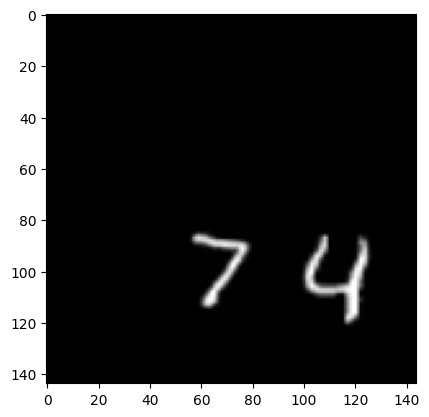

1
we extract the info!


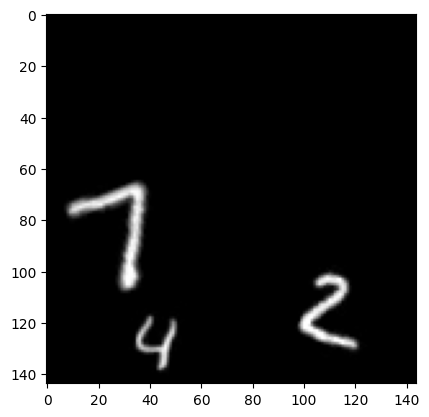

2
we extract the info!


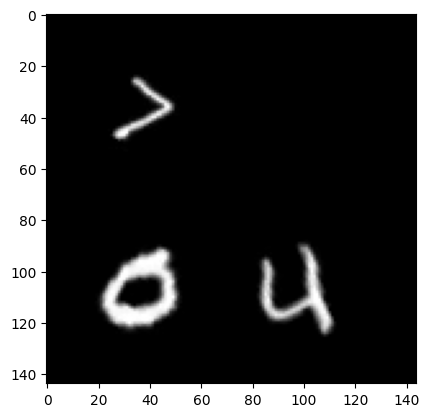

In [18]:
show_results(model, image[0:3,:,:,:], 7, 1, 10, threshold=0.5)

In [23]:
print(model(image)[0,:,:,6])

tf.Tensor(
[[0.14621173 0.10674774 0.05378829 0.10674774 0.14621171 0.11447202
  0.05926584]
 [0.0659855  0.10674774 0.10674774 0.10674774 0.05926584 0.0659855
  0.11447202]
 [0.16110124 0.1338416  0.11447202 0.10674774 0.07442379 0.04211191
  0.05378829]
 [0.05378829 0.04211191 0.10674774 0.05926584 0.13384162 0.10674774
  0.14621171]
 [0.0659855  0.10674774 0.10674774 0.10674774 0.11447202 0.1338416
  0.04923758]
 [0.14621171 0.10674774 0.16110124 0.10674774 0.12340136 0.0392703
  0.12340136]
 [0.10674774 0.10674774 0.05926584 0.14621171 0.10674774 0.12340136
  0.11447202]], shape=(7, 7), dtype=float32)


In [ ]:
predictions = tf.concat([image[:,:,:,0:10],image[:,:,:,-1:], image[:,:,:,10:-1]],axis=-1)

In [ ]:
print(predictions[0,:,:,:].shape)

In [ ]:
image_out[:,:,:,:].shape